In [1]:
from structuralcodes.codes.ec2_2004 import __materials__
from structuralcodes.materials.concrete import ConcreteEC2_2004,ConcreteEC2_2023
from structuralcodes.materials.reinforcement import ReinforcementEC2_2023,ReinforcementEC2_2004
from shapely import Polygon
from structuralcodes.geometry import SurfaceGeometry,CompoundGeometry,Geometry
from structuralcodes.sections._reinforcement import (
    add_reinforcement,
    add_reinforcement_line,
)
from structuralcodes.sections._generic import GenericSection
from structuralcodes.materials.constitutive_laws import Elastic, ElasticPlastic,ParabolaRectangle
from structuralcodes.plots.section_plots import draw_section,draw_constitutive_law,draw_My_Mz_diagram,draw_section_response,draw_N_M_diagram
import math
import matplotlib.pyplot as plt
import numpy as np


1) I can not compute gross properties of a secion from a SurfaceGeometry. It must be a CompoundGeometry

In [2]:
# Materials
concrete = ConcreteEC2_2004(25)
# Create section
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
#sec = GenericSection(geo)
#print(f"Area = {sec.gross_properties.area/(10**2)} cm2") # -> Error

sec = GenericSection(CompoundGeometry([geo]))
print(f"Area = {sec.gross_properties.area/(10**2)} cm2") 

Area = 1750.0 cm2


2) some properties are not working if coordinates are defined negative

I11 = 364583 cm2
I11_neg = 6823345 cm4
Sy = 43750 cm3
Sy_neg = 43750 cm3
I22 = 178646 cm2
I22_neg = 238634 cm4
Sz = 30625 cm3
Sz_neg = 30625 cm3


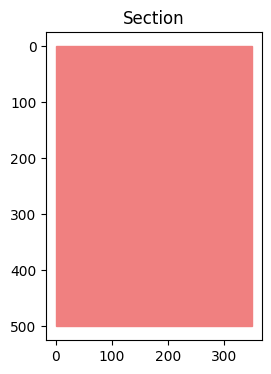

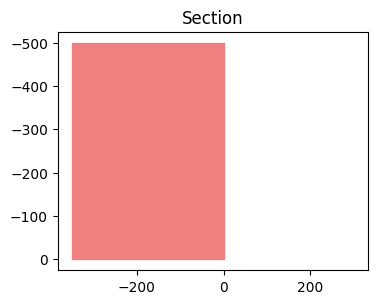

In [3]:
poly_neg = Polygon(((0, 0), (-350, 0), (-350, -500), (0, -500)))  # -500 instead of 500
geo_neg = SurfaceGeometry(poly_neg, concrete)
geo_neg = add_reinforcement_line(geo_neg, (50, -50), (300, -50), 0.01, concrete, n=2)
sec_neg = GenericSection(geo_neg)
print(f'I11 = {round(sec.gross_properties.i11/(10**4))} cm2') 
print(f'I11_neg = {round(sec_neg.gross_properties.i11/(10**4))} cm4')
print(f'Sy = {round(sec.gross_properties.sy/(10**3))} cm3') 
print(f'Sy_neg = {round(sec_neg.gross_properties.sy/(10**3))} cm3')

print(f'I22 = {round(sec.gross_properties.i22/(10**4))} cm2') 
print(f'I22_neg = {round(sec_neg.gross_properties.i22/(10**4))} cm4')
print(f'Sz = {round(sec.gross_properties.sz/(10**3))} cm3') 
print(f'Sz_neg = {round(sec_neg.gross_properties.sz/(10**3))} cm3')
draw_section(sec)
draw_section(sec_neg)

3)  should be "area" the total surface area (reinf + concrete)?

In [4]:
# Materials
concrete = ConcreteEC2_2004(25)
reinforcemnet = ReinforcementEC2_2023(fyk=500, Es=200000, density=7850, ftk=550, epsuk=0.07)  
# Create section
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(geo, (50, 450), (300, 450), 12, reinforcemnet, n=3)
geo = add_reinforcement_line(geo, (50, 50), (300, 50), 20, reinforcemnet, n=6)
sec = GenericSection(geo, integrator='marin')
print(f"area = {round(sec.gross_properties.area/(10**2))} cm2")
print(f"area_reinforcement = {round(sec.gross_properties.area_reinforcement/(10**2))} cm2")
print(f"area_surface = {round(sec.gross_properties.area_surface/(10**2))} cm2")

area = 1750 cm2
area_reinforcement = 22 cm2
area_surface = 1750 cm2


4. I dont undestand why:

- calculate_bending_strength(theta=0).m_z)

is not the same as:
- calculate_bending_strength(theta=math.pi/2).m_y

or:

- sec.geometry= sec.geometry.rotate(math.pi/2)
- calculate_bending_strength(theta=0).m_y)

which is the purpose of the m_z result?

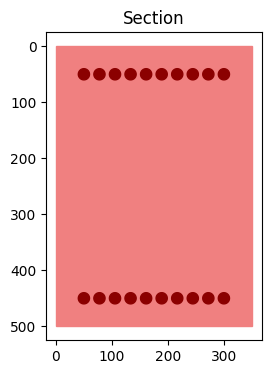

Mz_max [mkN]=0
Mz_max [mkN]=0


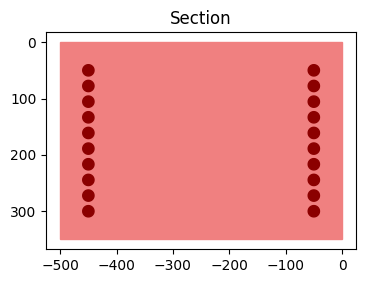

My_max_rotated [mkN]=-255


In [5]:
# Materials
concrete = ConcreteEC2_2004(25)
reinforcemnet = ReinforcementEC2_2023(fyk=500, Es=200000, density=7850, ftk=550, epsuk=0.07)  
# Create section
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(geo, (50, 450), (300, 450), 20, reinforcemnet, n=10)
geo = add_reinforcement_line(geo, (50, 50), (300, 50), 20, reinforcemnet, n=10)
sec = GenericSection(geo, integrator='marin')


draw_section(sec)
print(f"Mz_max [mkN]={round(sec.section_calculator.calculate_bending_strength(theta=0).m_z/1000**2)}")
print(f"Mz_max [mkN]={round(sec.section_calculator.calculate_bending_strength(theta=math.pi/2).m_y/1000**2)}")
sec.geometry= sec.geometry.rotate(math.pi/2)
draw_section(sec)
print(f"My_max_rotated [mkN]={round(sec.section_calculator.calculate_bending_strength(theta=0).m_y/1000**2)}")


5. Sign criteria in section class:

I am assuming z-axis downward. By default (theta=0) "calculate_bending_strength" gets negative value if "theta=0" correspondig with My_min; and positive if theta = pi/2 (My_max). It seem strange to me. At least it should be documented. 

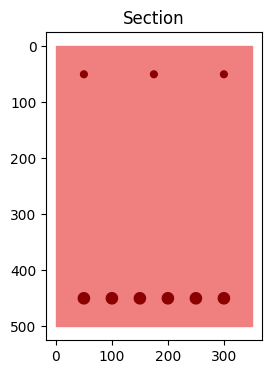

My_meg [mkN]=-69
My_pos [mkN]=324


In [6]:
# Materials
concrete = ConcreteEC2_2004(25)
reinforcemnet = ReinforcementEC2_2023(fyk=500, Es=200000, density=7850, ftk=550, epsuk=0.07)  
# Create section
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(geo, (50, 450), (300, 450), 20, reinforcemnet, n=6)
geo = add_reinforcement_line(geo, (50, 50), (300, 50), 12, reinforcemnet, n=3)
sec = GenericSection(geo)
draw_section(sec)

print(f"My_meg [mkN]={round(sec.section_calculator.calculate_bending_strength(theta=0).m_y/1000**2)}")
print(f"My_pos [mkN]={round(sec.section_calculator.calculate_bending_strength(theta=math.pi).m_y/1000**2)}")

6. Error when computing bending capacity with external axial load n<>0  (#1) or the section response for a given N-M (#2)

(if center of gravity is in the origin it works more or less ok.)

![N-M](error_N_M.png)


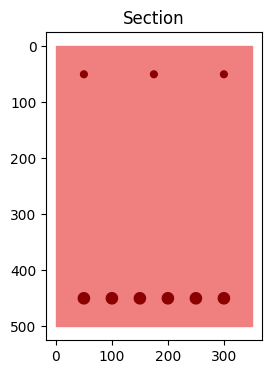

-3500 -1082.3516216091132
-3000 -1039.8614525599924
-2500 -968.2633649200853
-2000 -869.2276407658625
-1500 -715.0189200393919
-1000 -512.7545687674593
-500 -291.01410396661913
0 -65.77991375540094
500 160.05431990676033
900 343.05573912271814
-0.0007827106434851892
2.589796122664981e-06


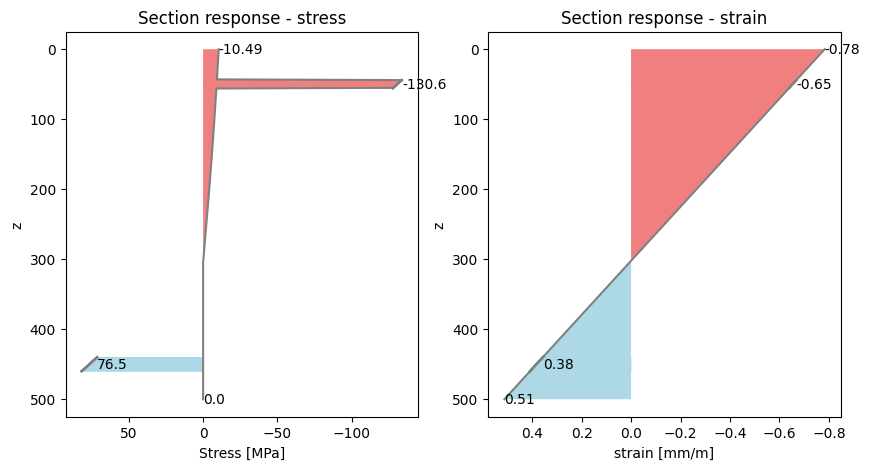

z neutral axis = 302.23


In [7]:
from  SLS_section_response import calculate_strain_profile
from  structuralcodes.plots.section_plots import draw_section_response, draw_N_M_diagram
concrete = ConcreteEC2_2004(25)
reinforcemnet = ReinforcementEC2_2004(fyk=500, Es=200000, density=7850, ftk=500, epsuk=0.07,)  
# Create section
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(geo, (50, 50), (300, 50), 12, reinforcemnet, n=3)
geo = add_reinforcement_line(geo, (50, 450), (300, 450), 20, reinforcemnet, n=6)
sec = GenericSection(geo)
#sec.geometry = sec.geometry.translate(0, -sec.gross_properties.cz) # -> uncomment this line and results will improve
draw_section(sec)

# 1
n_ = [-3500,-3000,-2500,-2000,-1500,-1000,-500,0,500,900] # kN
for n_ed in n_:
    print(n_ed,sec.section_calculator.calculate_bending_strength(0,n=n_ed*1e3).m_y/1e6)


# 2
my_ed =0 # mkN
n_ed=-500  # kN
#eps,chi= calculate_strain_profile(sec,n_ed,my_ed)
#draw_section_response(sec,eps,chi)
eps,chi= calculate_strain_profile(sec,n_ed*1e3,my_ed*1e6)
print(eps)
print(chi)
draw_section_response(sec,eps,chi)

Error copmputing bending stress with axial load comes from "integrate_strain_response_on_geometry" since the strain profile is validated


![N-M](N2000_my_min.png)

In [8]:
strain = sec.section_calculator.find_equilibrium_fixed_pivot(sec.geometry, n=-2000*1e3)
print(f'epsa= {strain[0]} similar to 2.703e-3 (validation result)' )
print(f'chi= {strain[1]} similar to 12.3e-6 (validation result)' )
print(f'my = {round(sec.section_calculator.calculate_bending_strength(0, n=-2000*1e3).m_y/1e6)} <> 348.85 (validation result)')

epsa= 0.002741093057504882 similar to 2.703e-3 (validation result)
chi= -1.248218611500977e-05 similar to 12.3e-6 (validation result)
my = -869 <> 348.85 (validation result)


7. How can we obtain the material of a part of a section? We only have access to the constitutive law of each geometry but not to the material. It could be useful to get for example if the constitutive law of concrete was created with gamma=1 or gamma=1.5 (maybe constitutive_law should have this attribute). It could also be important to store other attributes of the original material



8. I miss information about the units in the docstrings within the functions of the section classes.
- Force: N
- Moment: N*mm
- Dimensions: mm
- curvature: 1/mm

Also the sign criteria of internal moments in cross section, eps and curvature
- section_calculator.calculate_bending_strength(0).m_y -> returns a negative value. 

9. My-Mz diagram:
Small discrepancies in N=0. If axial load, something goes wrong.

N= 0 kN

![my-Mz](My_Mz_N_0kN.png)


N= -500 kN

![my-Mz](My_Mz_N_-500kN.png)


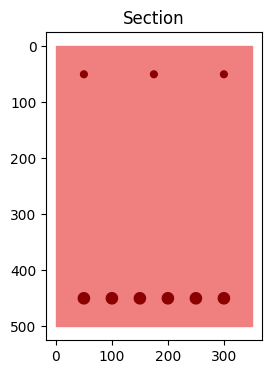

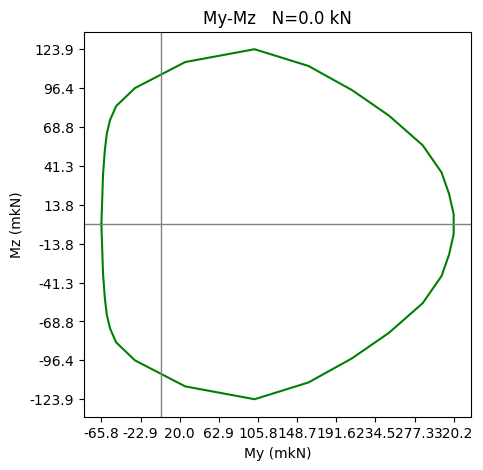

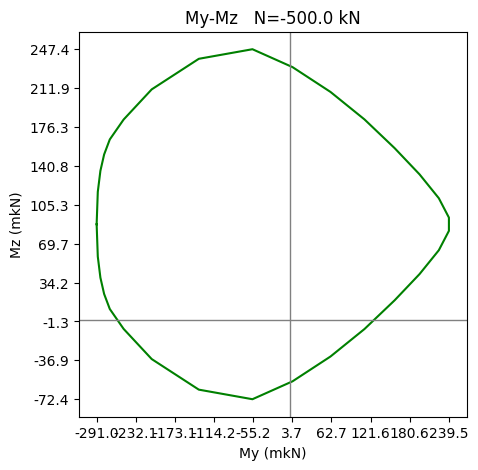

In [9]:
concrete = ConcreteEC2_2004(25)
reinforcemnet = ReinforcementEC2_2004(fyk=500, Es=200000, density=7850, ftk=500, epsuk=0.07,)  
# Create section
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(geo, (50, 50), (300, 50), 12, reinforcemnet, n=3)
geo = add_reinforcement_line(geo, (50, 450), (300, 450), 20, reinforcemnet, n=6)
sec = GenericSection(geo)
draw_section(sec)


n= 0 *1e3
res = sec.section_calculator.calculate_mm_interaction_domain(n)
draw_My_Mz_diagram(res,n,(5,5))
n= -500 *1e3
res = sec.section_calculator.calculate_mm_interaction_domain(n)
draw_My_Mz_diagram(res,n,(5,5))
#print(res.m_y)
#print('---------------')
#print(res.m_z)

10. N-M diagram:

Not working properly. It should be interesting to get the whole diagram  and not just the minimum range of M
(if center of gravity is in the origin it works more or less ok.)

![N-M](N_My.png)

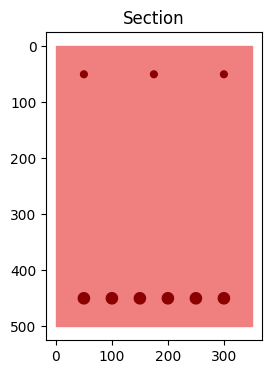

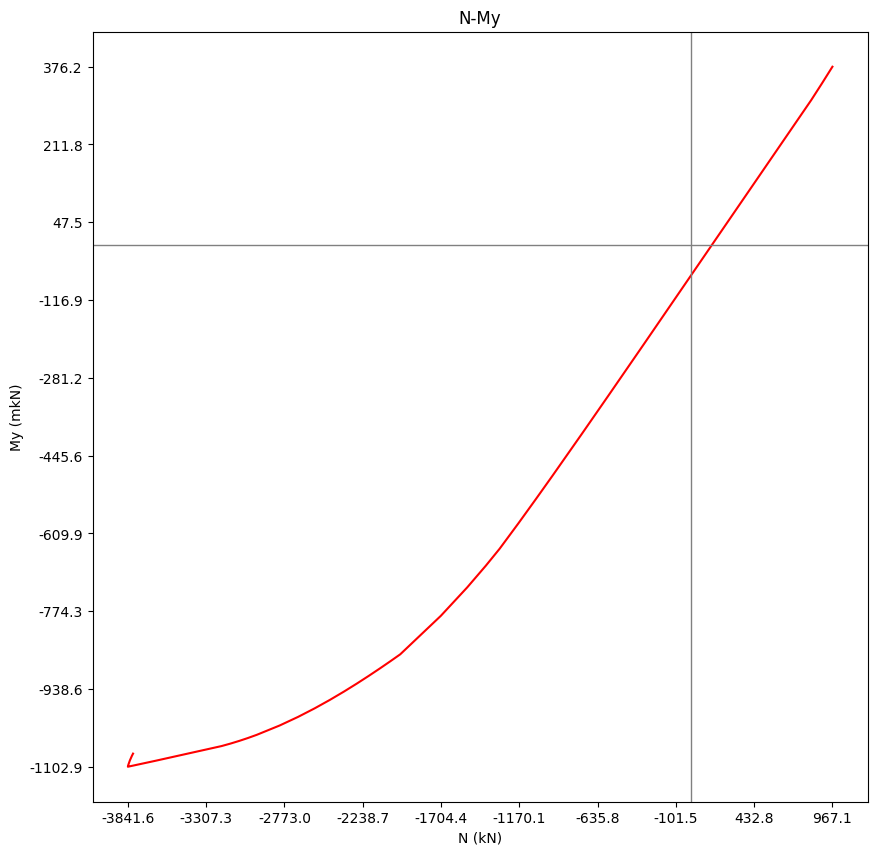

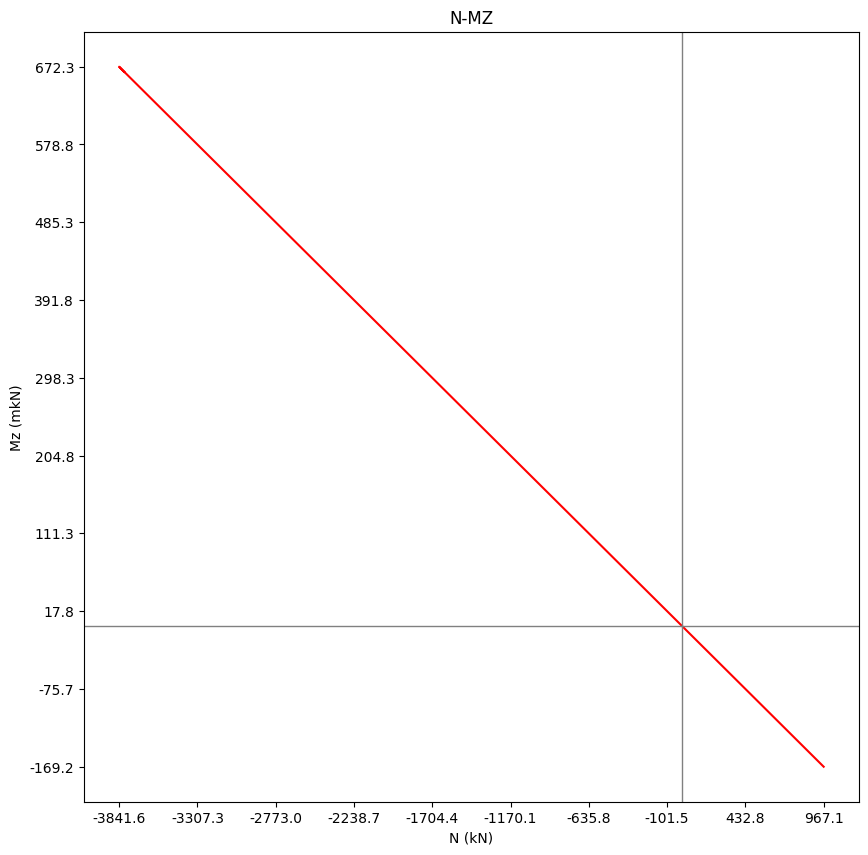

In [10]:
concrete = ConcreteEC2_2004(25)
reinforcemnet = ReinforcementEC2_2004(fyk=500, Es=200000, density=7850, ftk=500, epsuk=0.07)  
# Create section
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(geo, (50, 50), (300, 50), 12, reinforcemnet, n=3)
geo = add_reinforcement_line(geo, (50, 450), (300, 450), 20, reinforcemnet, n=6)
sec = GenericSection(geo)
# sec.geometry = sec.geometry.translate(0, -sec.gross_properties.cz) # -> uncomment this line and results will improve
draw_section(sec)


theta = 0
res = sec.section_calculator.calculate_nm_interaction_domain(theta)
draw_N_M_diagram(res)




11. Moment curvature results (fib package vs FH-PIEM)
- Something fails with axial load. if center of gravity is in the origin it works ok.
- Why only return the negative domain of curvature with theta=0?  Wouldn't it be better to have the whole domain instead of use theta parameter for that?
- The moment-curvature results should start at (0,0). I miss that point.

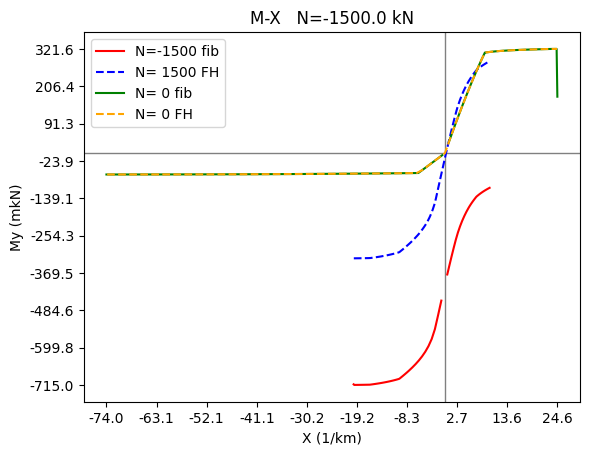

In [11]:
concrete = ConcreteEC2_2004(25)
reinforcemnet = ReinforcementEC2_2004(fyk=500, Es=200000, density=7850, ftk=500, epsuk=0.07,)  
# Create section
poly = Polygon(((0, 0), (350, 0), (350, 500), (0, 500)))
geo = SurfaceGeometry(poly, concrete)
geo = add_reinforcement_line(geo, (50, 50), (300, 50), 12, reinforcemnet, n=3)
geo = add_reinforcement_line(geo, (50, 450), (300, 450), 20, reinforcemnet, n=6)
sec = GenericSection(geo)
#sec.geometry = sec.geometry.translate(0, -sec.gross_properties.cz) # -> uncomment this line and results will improve

n=-1500 * 1e3

fig, ax = plt.subplots()
ax.set_title(f'M-X   N={n/1e3} kN')
ax.set_xlabel('X (1/km)')
ax.set_ylabel('My (mkN)')
ax.axhline(0, color='gray', linewidth=1)
ax.axvline(0, color='gray', linewidth=1)
xmin,xmax,ymin,ymax = 0,0,0,0

res = sec.section_calculator.calculate_moment_curvature(theta=0, n=n)
ax.plot(res.chi_y*1e6, res.m_y/1e6, color='red',  label='N=-1500 fib')
xmin = min(xmin, np.min(res.chi_y*1e6))
ymin= min(ymin,np.min(res.m_y/1e6))
xmax = max(xmax, np.max(res.chi_y*1e6))
ymax= max(ymax, np.max(res.m_y/1e6))
res = sec.section_calculator.calculate_moment_curvature(theta=math.pi, n=n)
ax.plot(res.chi_y*1e6, res.m_y/1e6, color='red')
xmin = min(xmin, np.min(res.chi_y*1e6))
ymin= min(ymin,np.min(res.m_y/1e6))
xmax = max(xmax, np.max(res.chi_y*1e6))
ymax= max(ymax, np.max(res.m_y/1e6))

#FH results
m1=[-324.42,-324.36,-324.3,-324.24,-324.18,-324.11,-324.03,-323.96,-323.87,-323.79,-323.69,-323.44,-322.81,-322.15,-321.47,-320.77,-320.03,-319.27,-318.47,-317.64,-316.78,-315.88,-314.93,-313.95,-312.91,-311.83,-310.69,-309.49,-308.23,-306.9,-305.35,-301.59,-297.76,-293.86,-289.88,-285.81,-281.64,-277.34,-272.91,-268.33,-263.57,-258.61,-253.43,-247.98,-242.22,-236.1,-229.57,-222.51,-214.83,-206.39,-196.94,-186.25,-173.91,-159.25,-141.39,-120.32,-99.1,-78.07,-56.94,-36.38,-15.46,-5.13,4.79,14.53,24.24,34.05,43.77,53.33,62.79,72.2,81.47,90.62,99.68,108.67,117.47,126.07,134.19,141.85,149.03,155.84,162.33,168.53,174.44,180.1,185.56,190.79,195.81,200.63,205.29,209.77,214.05,218.17,222.14,225.95,229.61,233.15,236.56,239.86,243.06,246.18,249.21,252.16,255.04,257.28,259.23,261.12,262.94,264.7,266.41,268.06,269.66,271.21,272.72,274.18,275.6,276.98,278.33,279.64,280.91,282.15,283.37
]
x1=[-19.92,-19.58,-19.25,-18.92,-18.59,-18.26,-17.92,-17.59,-17.26,-16.93,-16.6,-16.26,-15.93,-15.6,-15.27,-14.94,-14.6,-14.27,-13.94,-13.61,-13.28,-12.94,-12.61,-12.28,-11.95,-11.62,-11.29,-10.95,-10.62,-10.29,-9.96,-9.63,-9.29,-8.96,-8.63,-8.3,-7.97,-7.63,-7.3,-6.97,-6.64,-6.31,-5.97,-5.64,-5.31,-4.98,-4.65,-4.31,-3.98,-3.65,-3.32,-2.99,-2.66,-2.32,-1.99,-1.66,-1.33,-1,-0.66,-0.33,0,0.16,0.33,0.49,0.65,0.81,0.98,1.14,1.3,1.46,1.63,1.79,1.95,2.11,2.28,2.44,2.6,2.76,2.93,3.09,3.25,3.41,3.58,3.74,3.9,4.06,4.23,4.39,4.55,4.71,4.88,5.04,5.2,5.37,5.53,5.69,5.85,6.02,6.18,6.34,6.5,6.67,6.83,6.99,7.15,7.32,7.48,7.64,7.8,7.97,8.13,8.29,8.45,8.62,8.78,8.94,9.1,9.27,9.43,9.59,9.75
]
ax.plot(x1, m1, color='blue',  label='N= 1500 FH', linestyle='--')

n=0
res = sec.section_calculator.calculate_moment_curvature(theta=0, n=n)
ax.plot(res.chi_y*1e6, res.m_y/1e6, color='green',  label='N= 0 fib')
xmin = min(xmin, np.min(res.chi_y*1e6))
ymin= min(ymin,np.min(res.m_y/1e6))
xmax = max(xmax, np.max(res.chi_y*1e6))
ymax= max(ymax, np.max(res.m_y/1e6))
res = sec.section_calculator.calculate_moment_curvature(theta=math.pi, n=n)
ax.plot(res.chi_y*1e6, res.m_y/1e6, color='green')
xmin = min(xmin, np.min(res.chi_y*1e6))
ymin= min(ymin,np.min(res.m_y/1e6))
xmax = max(xmax, np.max(res.chi_y*1e6))
ymax= max(ymax, np.max(res.m_y/1e6))

#FH results
m1=[-65.77,-65.76,-65.74,-65.73,-65.71,-65.69,-65.67,-65.65,-65.63,-65.61,-65.58,-65.56,-65.53,-65.5,-65.47,-65.44,-65.41,-65.38,-65.34,-65.3,-65.26,-65.21,-65.17,-65.12,-65.06,-65.01,-64.94,-64.88,-64.81,-64.73,-64.65,-64.57,-64.48,-64.39,-64.3,-64.2,-64.09,-63.98,-63.87,-63.76,-63.64,-63.52,-63.39,-63.26,-63.12,-62.99,-62.84,-62.7,-62.55,-62.39,-62.23,-62.06,-61.88,-61.7,-61.49,-61.26,-51.88,-38.96,-26,-13,0,16.12,32.23,48.29,64.12,79.85,95.42,110.84,126.11,141.19,156.11,170.82,185.35,199.67,213.78,227.66,241.3,254.69,267.82,280.66,293.21,305.43,310.76,311.55,312.26,312.92,313.52,314.07,314.58,315.05,315.48,315.88,316.26,316.61,316.94,317.25,317.55,317.82,318.09,318.34,318.58,318.81,319.03,319.24,319.44,319.64,319.83,320.01,320.19,320.36,320.52,320.68,320.84,320.99,321.14,321.28,321.42,321.51,321.55,321.59,321.62
]
x1=[-73.87,-72.64,-71.4,-70.17,-68.94,-67.71,-66.48,-65.25,-64.02,-62.79,-61.56,-60.32,-59.09,-57.86,-56.63,-55.4,-54.17,-52.94,-51.71,-50.48,-49.24,-48.01,-46.78,-45.55,-44.32,-43.09,-41.86,-40.63,-39.4,-38.16,-36.93,-35.7,-34.47,-33.24,-32.01,-30.78,-29.55,-28.32,-27.08,-25.85,-24.62,-23.39,-22.16,-20.93,-19.7,-18.47,-17.24,-16,-14.77,-13.54,-12.31,-11.08,-9.85,-8.62,-7.39,-6.16,-4.92,-3.69,-2.46,-1.23,0,0.41,0.82,1.23,1.63,2.04,2.45,2.86,3.27,3.68,4.09,4.5,4.9,5.31,5.72,6.13,6.54,6.95,7.36,7.76,8.17,8.58,8.99,9.4,9.81,10.22,10.63,11.03,11.44,11.85,12.26,12.67,13.08,13.49,13.9,14.3,14.71,15.12,15.53,15.94,16.35,16.76,17.16,17.57,17.98,18.39,18.8,19.21,19.62,20.03,20.43,20.84,21.25,21.66,22.07,22.48,22.89,23.29,23.7,24.11,24.52
]
ax.plot(x1, m1, color='orange',  label='N= 0 FH', linestyle='--')

x_legend = np.linspace(xmin, xmax, 10)
y_legend = np.linspace(ymin, ymax, 10)
ax.set_xticks(x_legend)
ax.set_yticks(y_legend)
ax.set_xticklabels(np.around(x_legend, decimals=1))
ax.set_yticklabels(np.around(y_legend, decimals=1))
plt.legend()
plt.show()




12. When calculating the geometric properties EA, EI uses the tangent modulus at eps=0. With concrete it does not use Ecm. 
In order to homogenise a section it is now necessary to adapt Es =Ec,tang.
Would be usefull to get section properties in homogenised section using Ecm. Instead of using E=constitutive_law.get_tangent(0)[0], a parameter of E could be entered for each material just for gross properties calculation. The default should be Ecm for concrete and constitutive_law.get_tangent(0)[0] for others.




Should be SurfaceGeometry class inherited from Geometry class??